In [1]:
import pandas as pd
from sklearn import metrics
from scipy.io import loadmat
from os.path import exists
from tqdm import tqdm
from scipy.linalg import toeplitz
import time
import scipy
import os
import matplotlib.colors as mcolors 
from mpl_toolkits.axes_grid1 import make_axes_locatable
import sys
import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from importlib import reload
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
import cooler
import cooltools

sys.path.append("../../source/")
import utils as ut
import matrix
import plotting as plt2

In [2]:
dpath = "/nfs/turbo/umms-indikar/shared/projects/poreC/pipeline_outputs/population/align_table/"

df = []
for f in os.listdir(dpath):
    if not 'parquet' in f:
        continue

    fpath = f"{dpath}{f}"
    tmp = pd.read_parquet(fpath)
    print(f, tmp.shape)
    df.append(tmp)

df = pd.concat(df)
print(f"{df.shape=}")
"""
batch04.GRCm39.align_table.parquet (8434829, 16)
batch02.GRCm39.align_table.parquet (907344, 16)
batch03.GRCm39.align_table.parquet (4579554, 16)
batch01.GRCm39.align_table.parquet (7508851, 16)
df.shape=(21430578, 16)
"""

df.head()

batch02.GRCm39.align_table.parquet (907344, 15)
batch03.GRCm39.align_table.parquet (4579554, 15)
batch04.GRCm39.align_table.parquet (8434829, 15)
batch01.GRCm39.align_table.parquet (7508851, 15)
df.shape=(21430578, 15)


read_name  align_id  read_start  read_end  \
0  00000b61-7794-4b29-9f89-2b74e7bbce3e    457681           0         8   
1  00000b61-7794-4b29-9f89-2b74e7bbce3e    457682           8       400   
2  00000b61-7794-4b29-9f89-2b74e7bbce3e    457683         400       553   
3  00000b61-7794-4b29-9f89-2b74e7bbce3e    457684         553       611   
4  00000b61-7794-4b29-9f89-2b74e7bbce3e    457685         611       759   

   length_on_read chrom  ref_start      ref_end  fragment_id  fragment_start  \
0               8   NaN         -1          NaN          NaN             NaN   
1             392    15   40952485   40952851.0    9795761.0      40952505.0   
2             153     1  153345218  153345369.0     726712.0     153345224.0   
3              58   NaN         -1          NaN          NaN             NaN   
4             148    16   13896976   13897125.0   10167250.0      13896982.0   

   fragment_end  fragment_length  monomer_duplicate  is_mapped  \
0           NaN              NaN              False      False   
1    40952862.0            357.0              False       True   
2   153345375.0            151.0              False       True   
3           NaN              NaN              False      False   
4    13897055.0             73.0              False       True   

   mapping_quality  
0                0  
1               60  
2               60  
3                0  
4               36

In [3]:
def filter_and_prepare_data(df, resolution, mapq=60):
    """Filters and prepares contact data for analysis.

    Args:
        df (pd.DataFrame): The raw DataFrame containing contact data.
        resolution (int): The desired genomic resolution for binning.
        mapq (int, optional): The minimum mapping quality to filter by. Defaults to 60.

    Returns:
        pd.DataFrame: The filtered and processed DataFrame.
    """
    # Filtering
    filtered_df = df[df['mapping_quality'] >= mapq].copy()  # Filter by MAPQ
    filtered_df = filtered_df[filtered_df['fragment_id'].notna()] 

    # Binning
    filtered_df['bin'] = filtered_df['ref_start'].apply(lambda x: ut.bin_loci(x, resolution))
    return filtered_df  

resolution = 1000000
# resolution = 100000
# mapq = 60
mapq = 1
resolution_str = ut.human_readable_bp(resolution)  
print(f"Binning at {resolution_str} with mapq == {mapq}")
pdf = filter_and_prepare_data(df, resolution, mapq=mapq)
print(f"{pdf.shape=}")
pdf.head()

Binning at 1Mb with mapq == 1
pdf.shape=(14731046, 16)


read_name  align_id  read_start  read_end  \
1  00000b61-7794-4b29-9f89-2b74e7bbce3e    457682           8       400   
2  00000b61-7794-4b29-9f89-2b74e7bbce3e    457683         400       553   
4  00000b61-7794-4b29-9f89-2b74e7bbce3e    457685         611       759   
6  00000b61-7794-4b29-9f89-2b74e7bbce3e    457687         810      1110   
7  000047b3-2703-4687-9978-37722f5619da    216604           0      1025   

   length_on_read chrom  ref_start      ref_end  fragment_id  fragment_start  \
1             392    15   40952485   40952851.0    9795761.0      40952505.0   
2             153     1  153345218  153345369.0     726712.0     153345224.0   
4             148    16   13896976   13897125.0   10167250.0      13896982.0   
6             300     4   99871359   99871640.0    3005929.0      99871361.0   
7            1025     4   31146588   31147172.0    2681214.0      31146590.0   

   fragment_end  fragment_length  monomer_duplicate  is_mapped  \
1    40952862.0            357.0              False       True   
2   153345375.0            151.0              False       True   
4    13897055.0             73.0              False       True   
6    99871646.0            285.0              False       True   
7    31147179.0            589.0              False       True   

   mapping_quality    bin  
1               60   41.0  
2               60  154.0  
4               36   14.0  
6               60  100.0  
7               60   32.0

In [4]:
chrom = "1"
order_threshold = 2
sample_size = 1000

pdf = pdf[pdf['chrom'] == chrom]
print(f"{pdf.shape=}")

I, read_map = ut.process_chromosome_data(pdf, 
                                         order_threshold=order_threshold, 
                                         sample_size=sample_size)

print(f"{I.shape=}")
I.head()

pdf.shape=(993345, 16)
I.shape=(193, 1000)


read_code  9881   14479  19729  37786  26272  24437  36179  16788  3354   \
bin                                                                        
4.0          0.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0   
5.0          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
6.0          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
7.0          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
8.0          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

read_code  15485  ...  10348  21346  15612  32344  25422  14971  30274  35770  \
bin               ...                                                           
4.0          0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
5.0          0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
6.0          0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
7.0          0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
8.0          0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

read_code  7907   8446   
bin                      
4.0          0.0    0.0  
5.0          0.0    0.0  
6.0          0.0    0.0  
7.0          0.0    0.0  
8.0          0.0    0.0  

[5 rows x 1000 columns]

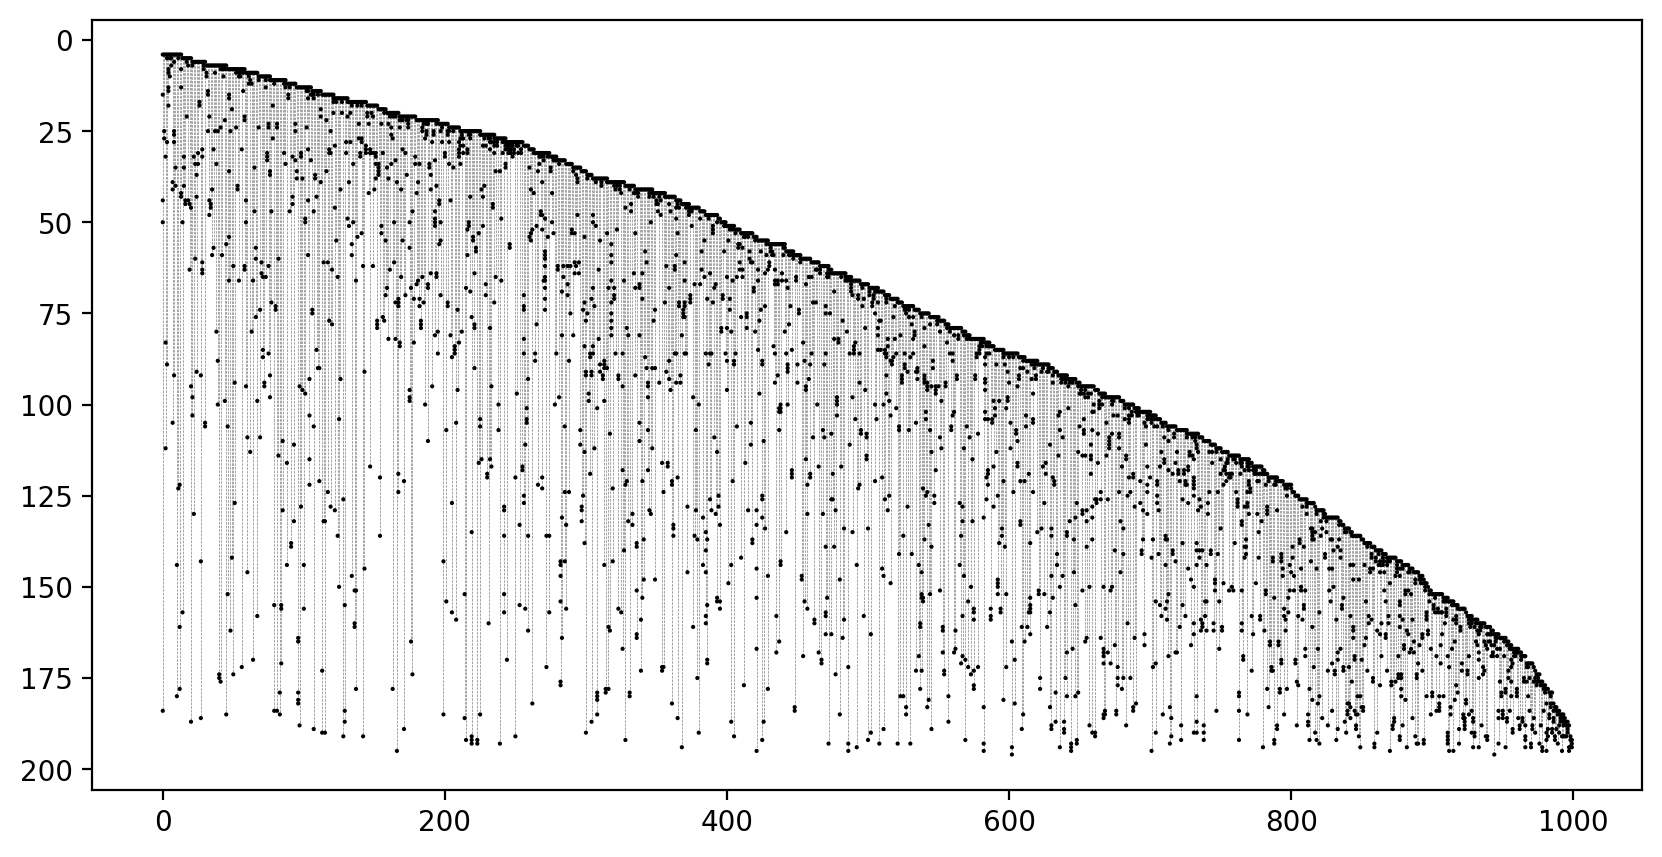

A.shape=(193, 193)


In [5]:
reload(plt2)
reload(ut)

node_params = {
    's' : 1,
    'ec' : 'k',
    'lw' : 0.5,
    'zorder' : 2,
}

line_params = {
    'lw' : 0.25,
    'alpha' : 0.5,
    'zorder' : 1,
    'ls' : '--',
}

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 10, 5
plt2.plot_incidence(ut.sort_by_lowest_index(I), 
               node_color='k',
               node_params=node_params,
               line_params=line_params)

plt.show()
A = matrix.clique_expand_incidence(I, zero_diag=False)   
print(f"{A.shape=}")
# plt.imshow(matrix.normalize_kr(A).todense())
# plt.xticks([])
# plt.show()

In [6]:
# break

Text(0.5, 0, 'Singular Value Index')

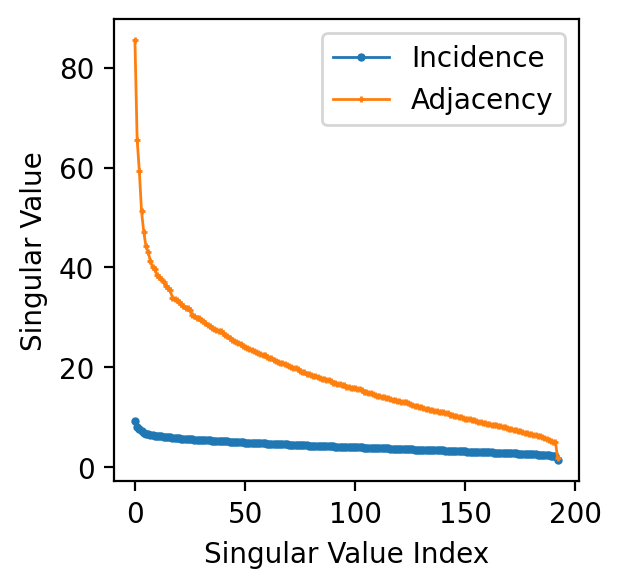

In [7]:
u_i, s_i, vh_i = np.linalg.svd(I)
u_a, s_a, vh_a = np.linalg.svd(A)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 3
plt.plot(s_i, lw=1, marker="o", markersize=2, label='Incidence')
plt.plot(s_a, lw=1, marker="+", markersize=2, label='Adjacency')
plt.legend()

plt.ylabel('Singular Value')
plt.xlabel('Singular Value Index')

In [8]:
# reload(ut)

# plt.rcParams['figure.dpi'] = 200
# plt.rcParams['figure.figsize'] = 3, 3
# plt.plot(ut.normalize_1d_array(s_i), lw=1, marker="o", markersize=2, label='Incidence')
# plt.plot(ut.normalize_1d_array(s_a), lw=1, marker="+", markersize=2, label='Adjacency')
# plt.legend()

# plt.ylabel('Normalized Singular Value')
# plt.xlabel('Singular Value Index')

In [9]:
# break

# all chrom 1

In [10]:
reload(ut)
chrom = "1"
order_threshold = 1

pdf = pdf[pdf['chrom'] == chrom]
print(f"{pdf.shape=}")

I, read_map = ut.process_chromosome_data(pdf, 
                                         order_threshold=order_threshold, 
                                         sample_size=None)

Apc = matrix.clique_expand_incidence(I, zero_diag=False)
print(f"{I.shape=} {Apc.shape=}")

pdf.shape=(993345, 17)
I.shape=(193, 122676) Apc.shape=(193, 193)


Text(0.5, 0, 'Order (Unique 1Mb Bins)')

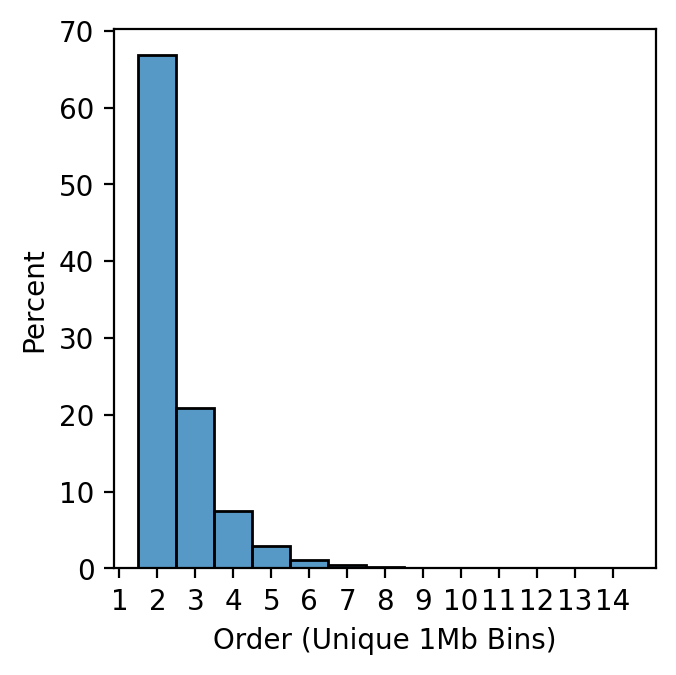

In [11]:
# plot the contact order of the population pore-c

degree = I.sum(axis=0)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3.5, 3.5
sns.histplot(x=degree, 
             discrete=True,
             stat='percent',
            )

plt.xticks(list(range(1, 15)))
plt.xlabel('Order (Unique 1Mb Bins)')


In [12]:
# break

# load the pop hi-c

In [13]:
fpath = "/nfs/turbo/umms-indikar/shared/projects/poreC/data/f1219_population_hic/4DNFICF9PA9C.mcool"

chrom = "chr1"
clr = cooler.Cooler(f'{fpath}::resolutions/{resolution}')
Ahic = clr.matrix(balance=False).fetch(str(chrom))[:]
Ahic = np.nan_to_num(Ahic)
print(f"{Ahic.shape=}")

# drop the telomere
Ahic = Ahic[3:, :][:, 3:]
print(f"{Ahic.shape=}")

Ahic.shape=(196, 196)
Ahic.shape=(193, 193)


# drop problematic indices

In [14]:
print(type(Apc))
print(type(Ahic))

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>


In [15]:
# break

In [16]:
reload(ut)

Apc = matrix.remove_indices(Apc.to_numpy(), [84, 85, 192])
Ahic = matrix.remove_indices(Ahic, [84, 85, 192])

print(f"{Apc.shape=}")
print(f"{Apc.sum()=}")
print(f"{Apc.mean()=:.3f}")
print(f"{Apc.max()=}")

print()
print(f"{Ahic.shape=}")
print(f"{Ahic.sum()=}")
print(f"{Ahic.mean()=:.3f}")
print(f"{Ahic.max()=}")

Apc.shape=(190, 190)
Apc.sum()=882684.0
Apc.mean()=24.451
Apc.max()=2894.0

Ahic.shape=(190, 190)
Ahic.sum()=13851731
Ahic.mean()=383.704
Ahic.max()=137482


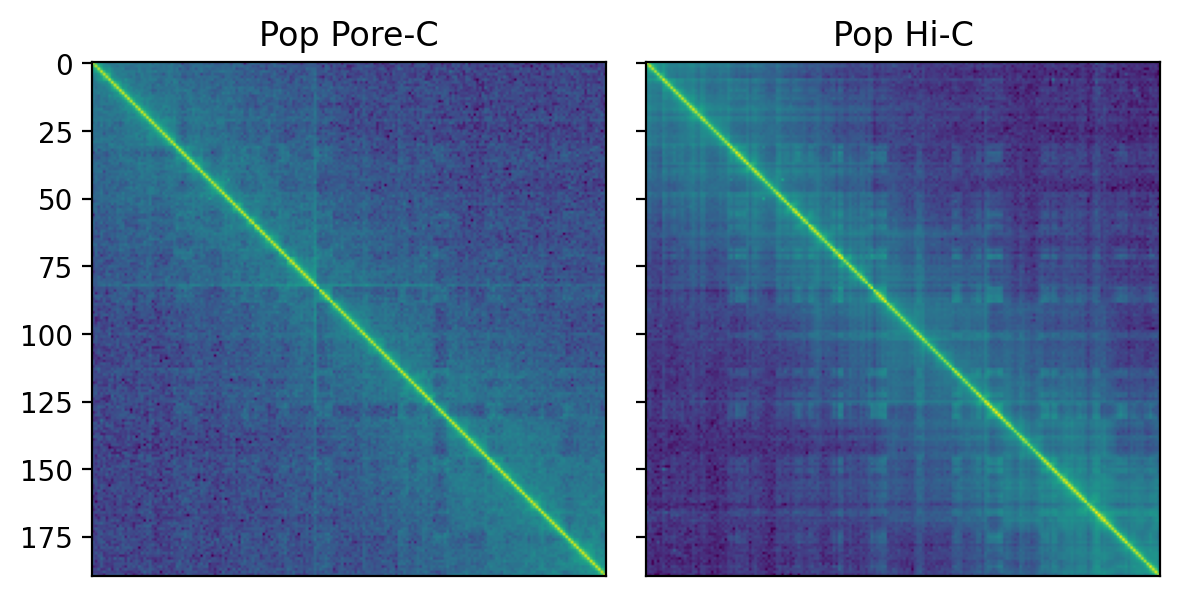

In [17]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 3

fig, axs = plt.subplots(1, 2, sharey=True)
axs[0].imshow(np.log1p(Apc))
axs[1].imshow(np.log1p(Ahic))

axs[0].set_title('Pop Pore-C')
axs[1].set_title('Pop Hi-C')

axs[0].set_xticks([])
axs[1].set_xticks([])
plt.tight_layout()

In [18]:
# break

Apc_norm.shape=(190, 190)
Ahic_norm.shape=(190, 190)


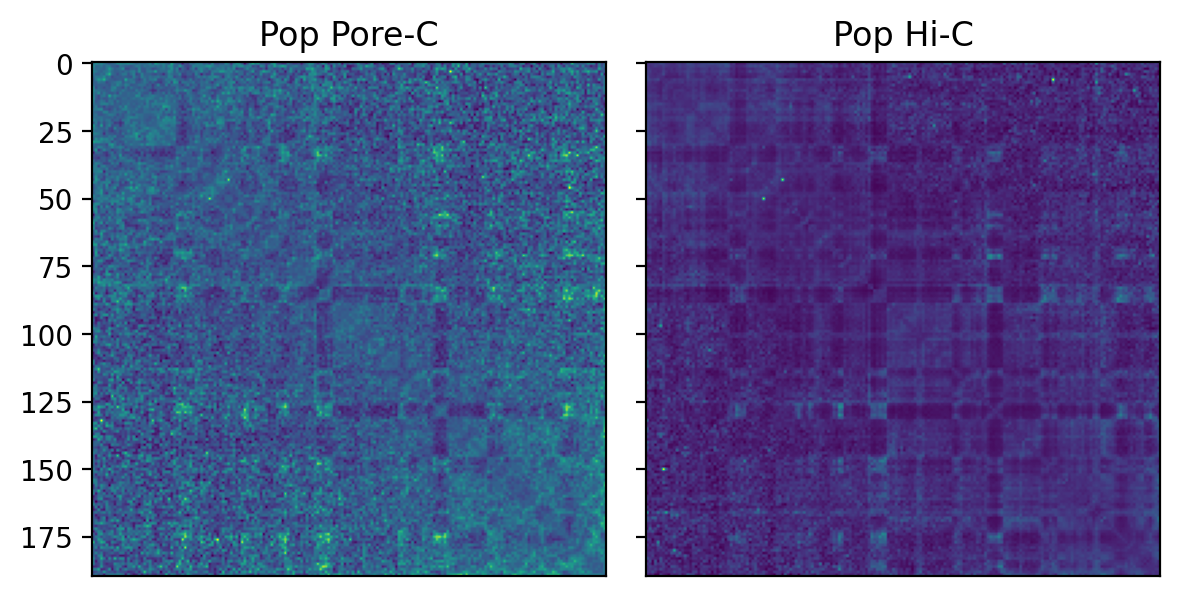

In [19]:
# normalized
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 3
fig, axs = plt.subplots(1, 2, sharey=True)

Apc_norm = matrix.normalize_oe(matrix.normalize_kr(Apc).todense())
Ahic_norm = matrix.normalize_oe(matrix.normalize_kr(Ahic).todense())

print(f"{Apc_norm.shape=}")
print(f"{Ahic_norm.shape=}")

axs[0].imshow(Apc_norm)
axs[1].imshow(Ahic_norm)

axs[0].set_title('Pop Pore-C')
axs[1].set_title('Pop Hi-C')

axs[0].set_xticks([])
axs[1].set_xticks([])
plt.tight_layout()

(36100,) (36100,)


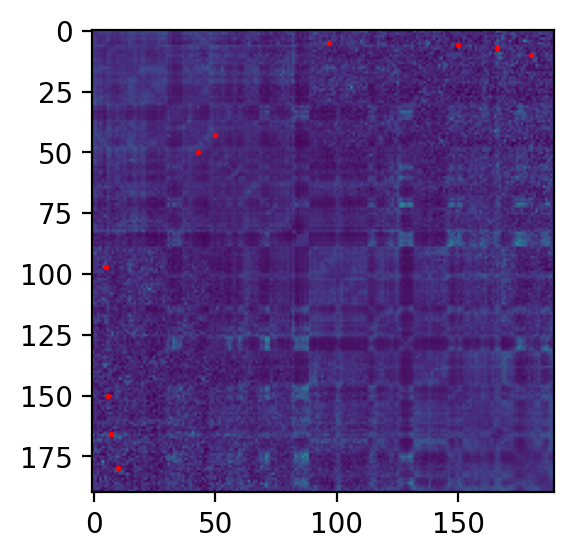

In [20]:
reload(ut)

top = 10
row_idx, col_idx = matrix.get_sorted_upper_triangle_indices(Ahic_norm)
print(row_idx.shape, col_idx.shape)

plt.imshow(Ahic_norm)

for i in range(top):
    plt.scatter(row_idx[i], col_idx[i], s=1, c='r')

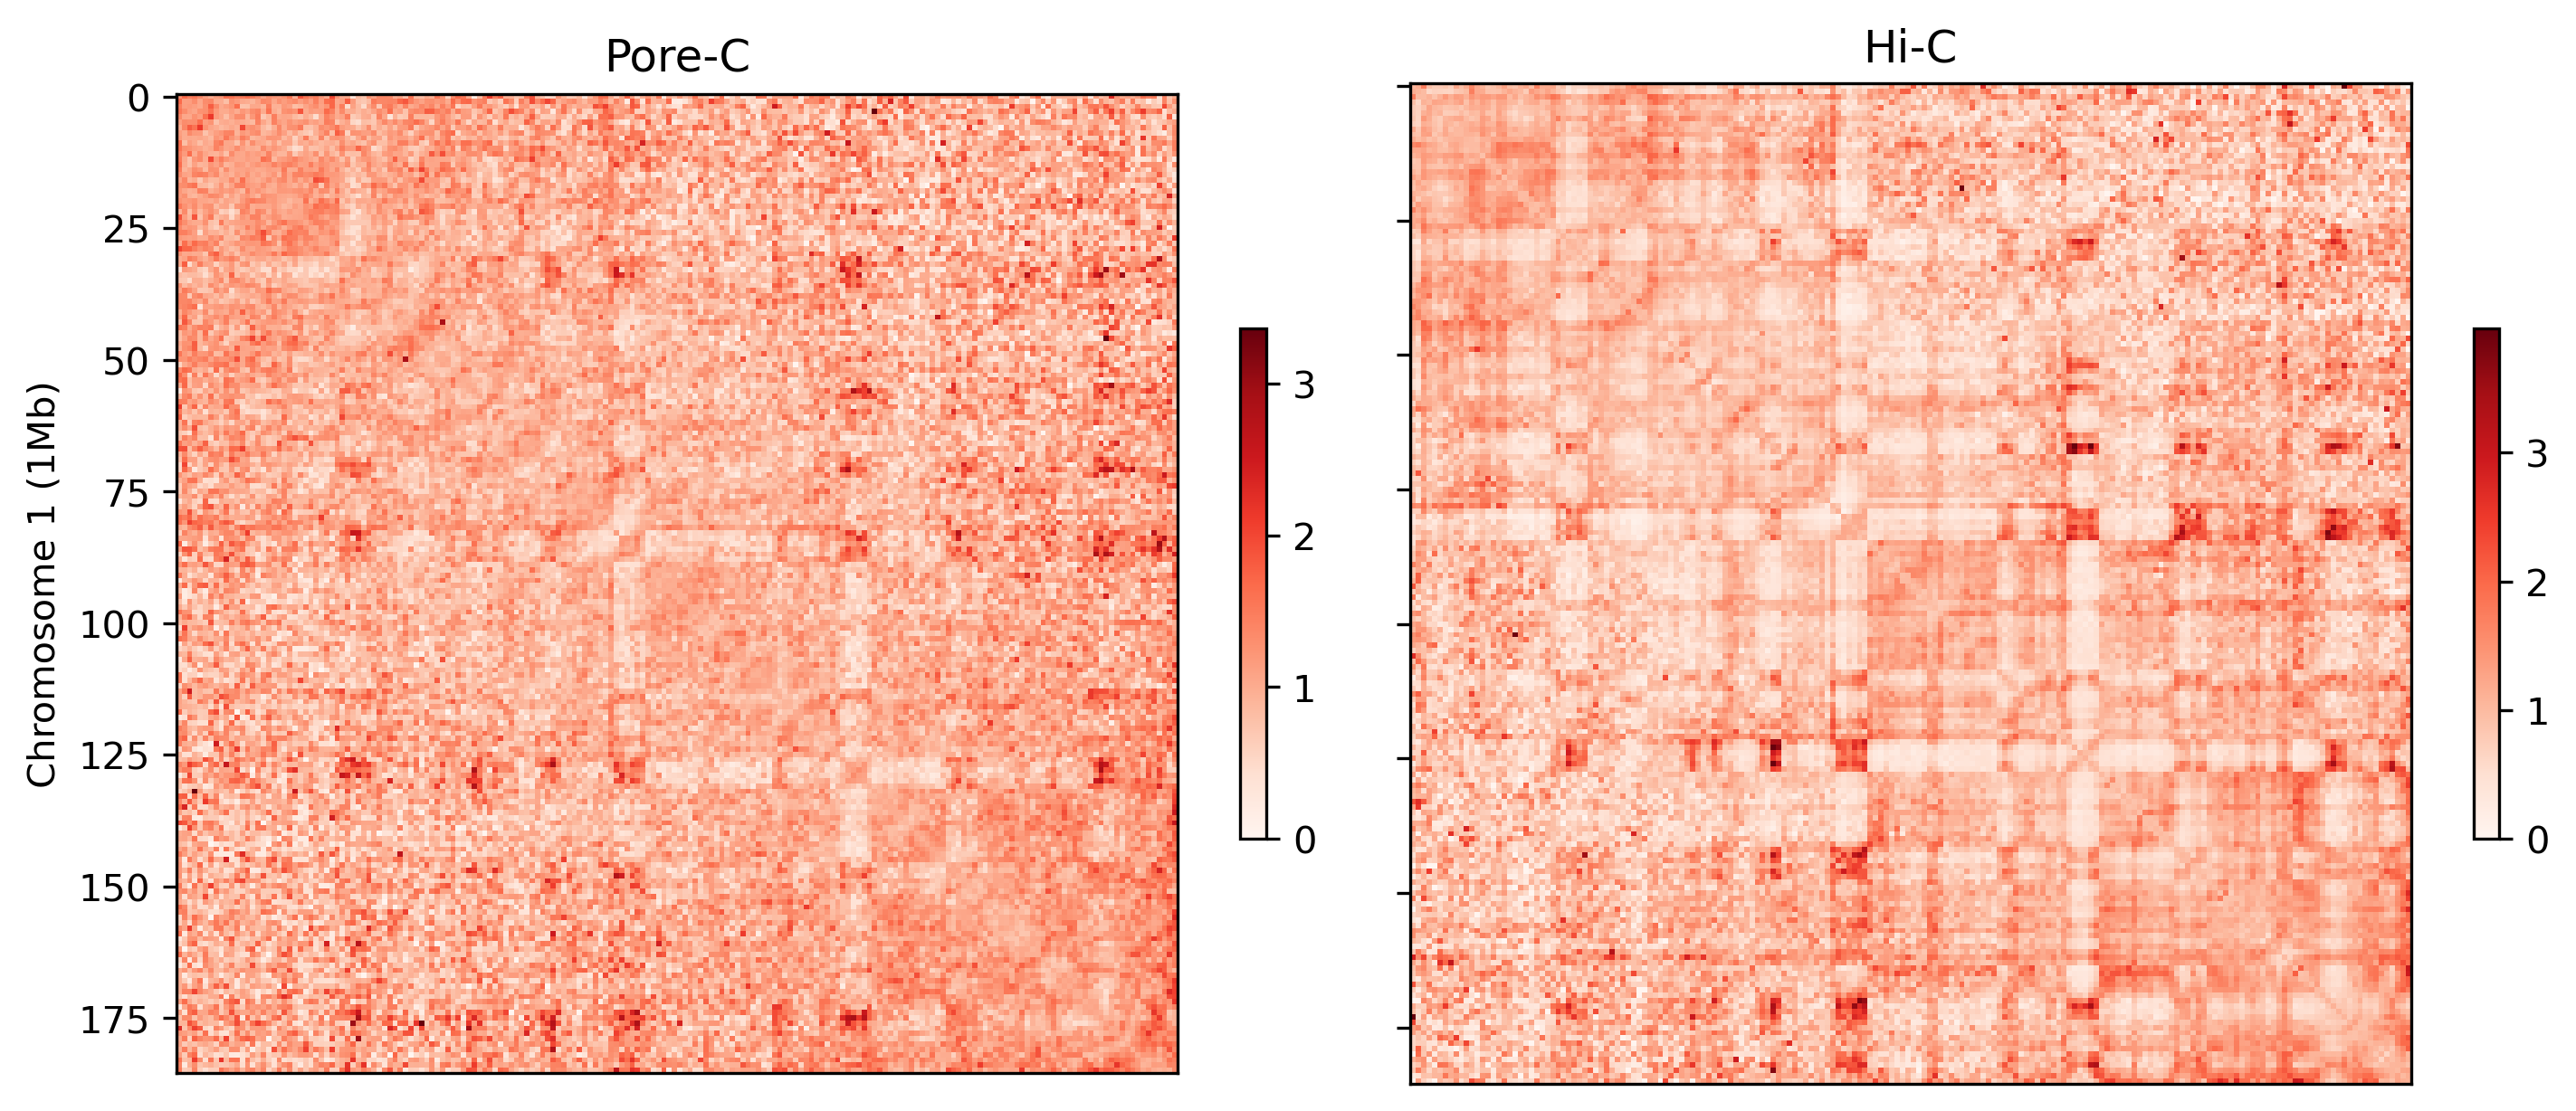

In [21]:


# update the matrix 
for i in range(top):
    Ahic_norm[row_idx[i], col_idx[i]] = Ahic_norm.mean()

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 10, 5
fig, axs = plt.subplots(1, 2, sharey=True)

im1 = axs[0].imshow(Apc_norm , cmap='Reds')
im2 = axs[1].imshow(Ahic_norm[4:190, 4:190], cmap='Reds')

cbar1 = plt.colorbar(im1, ax=axs[0], shrink=0.4)  
cbar2 = plt.colorbar(im2, ax=axs[1], shrink=0.4)  

axs[0].set_title('Pore-C')
axs[1].set_title('Hi-C')

axs[0].set_ylabel("Chromosome 1 (1Mb)")

axs[0].set_xticks([])
axs[1].set_xticks([])
plt.tight_layout()

Apc_norm.shape=(190, 190)
Ahic_norm.shape=(190, 190)


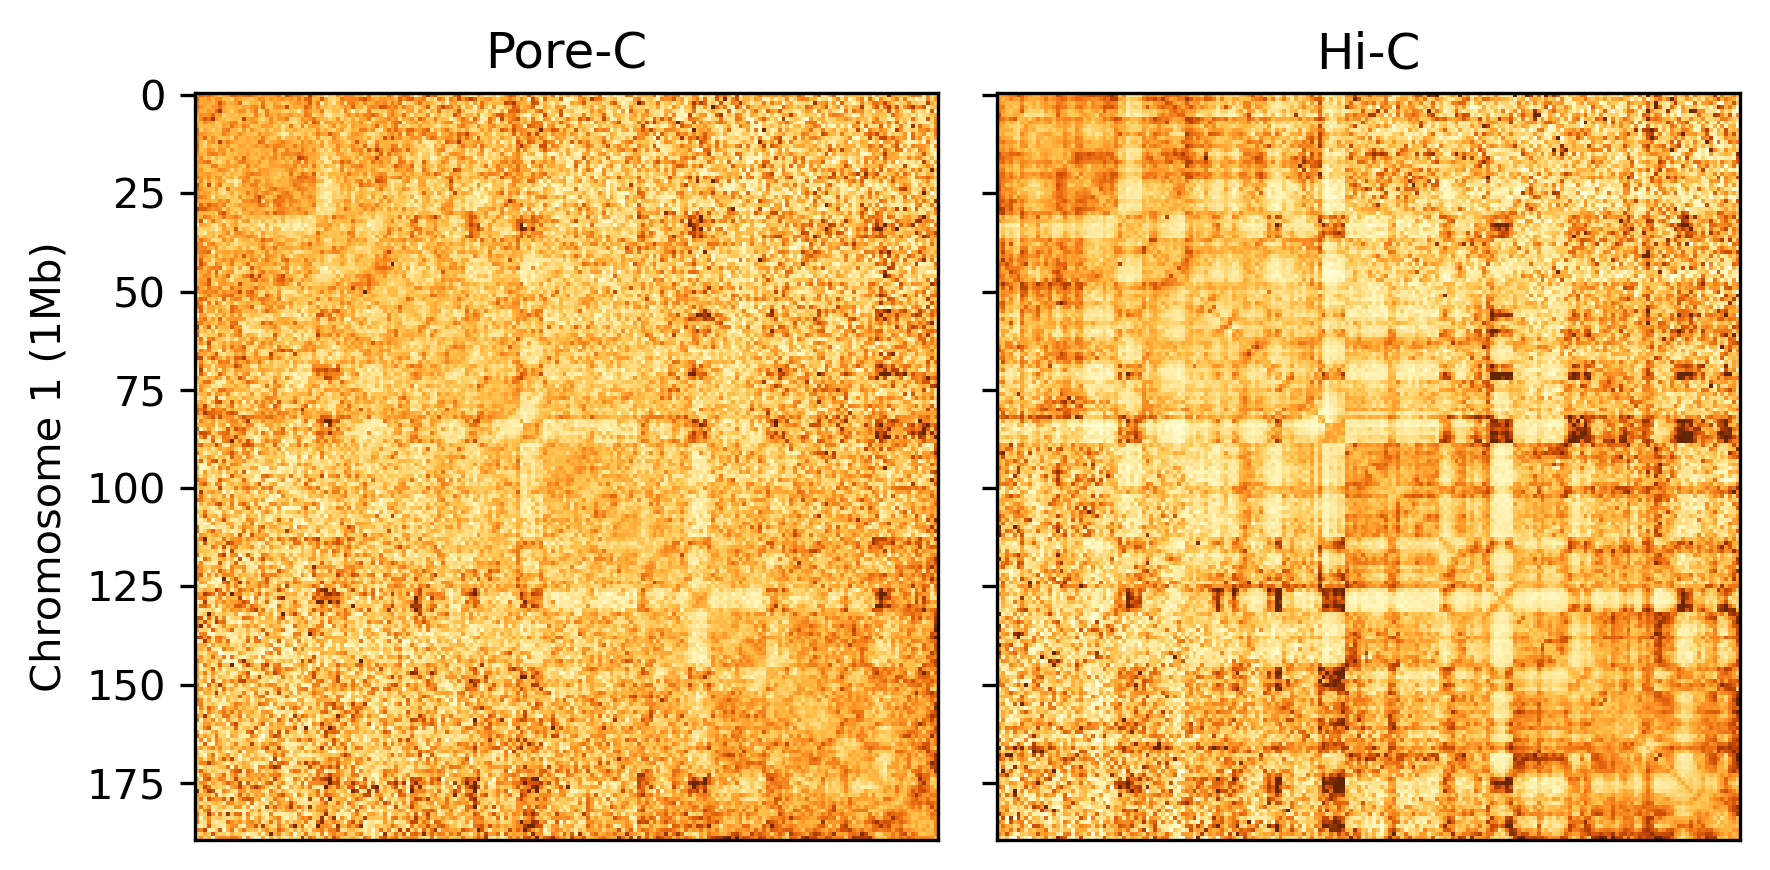

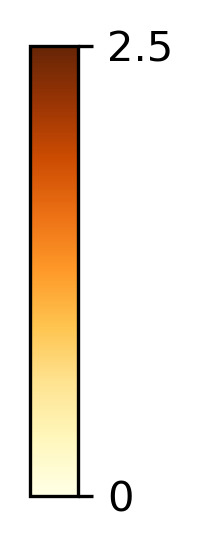

In [22]:
cmap = 'YlOrBr'
vmax = 2.5

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 3

fig, axs = plt.subplots(1, 2, sharey=True,)

print(f"{Apc_norm.shape=}")
print(f"{Ahic_norm.shape=}")

im1 = axs[0].imshow(Apc_norm , cmap=cmap, vmax=vmax, aspect='auto')
im2 = axs[1].imshow(Ahic_norm, cmap=cmap, vmax=vmax, aspect='auto')

axs[0].set_title('Pore-C')
axs[1].set_title('Hi-C')

axs[0].set_ylabel("Chromosome 1 (1Mb)")

axs[0].set_xticks([])
axs[1].set_xticks([])
plt.tight_layout()
plt.show()

plt2.make_colorbar(cmap, tick_labels=[0, vmax])

Apc_norm.shape=(190, 190)
Ahic_norm.shape=(190, 190)


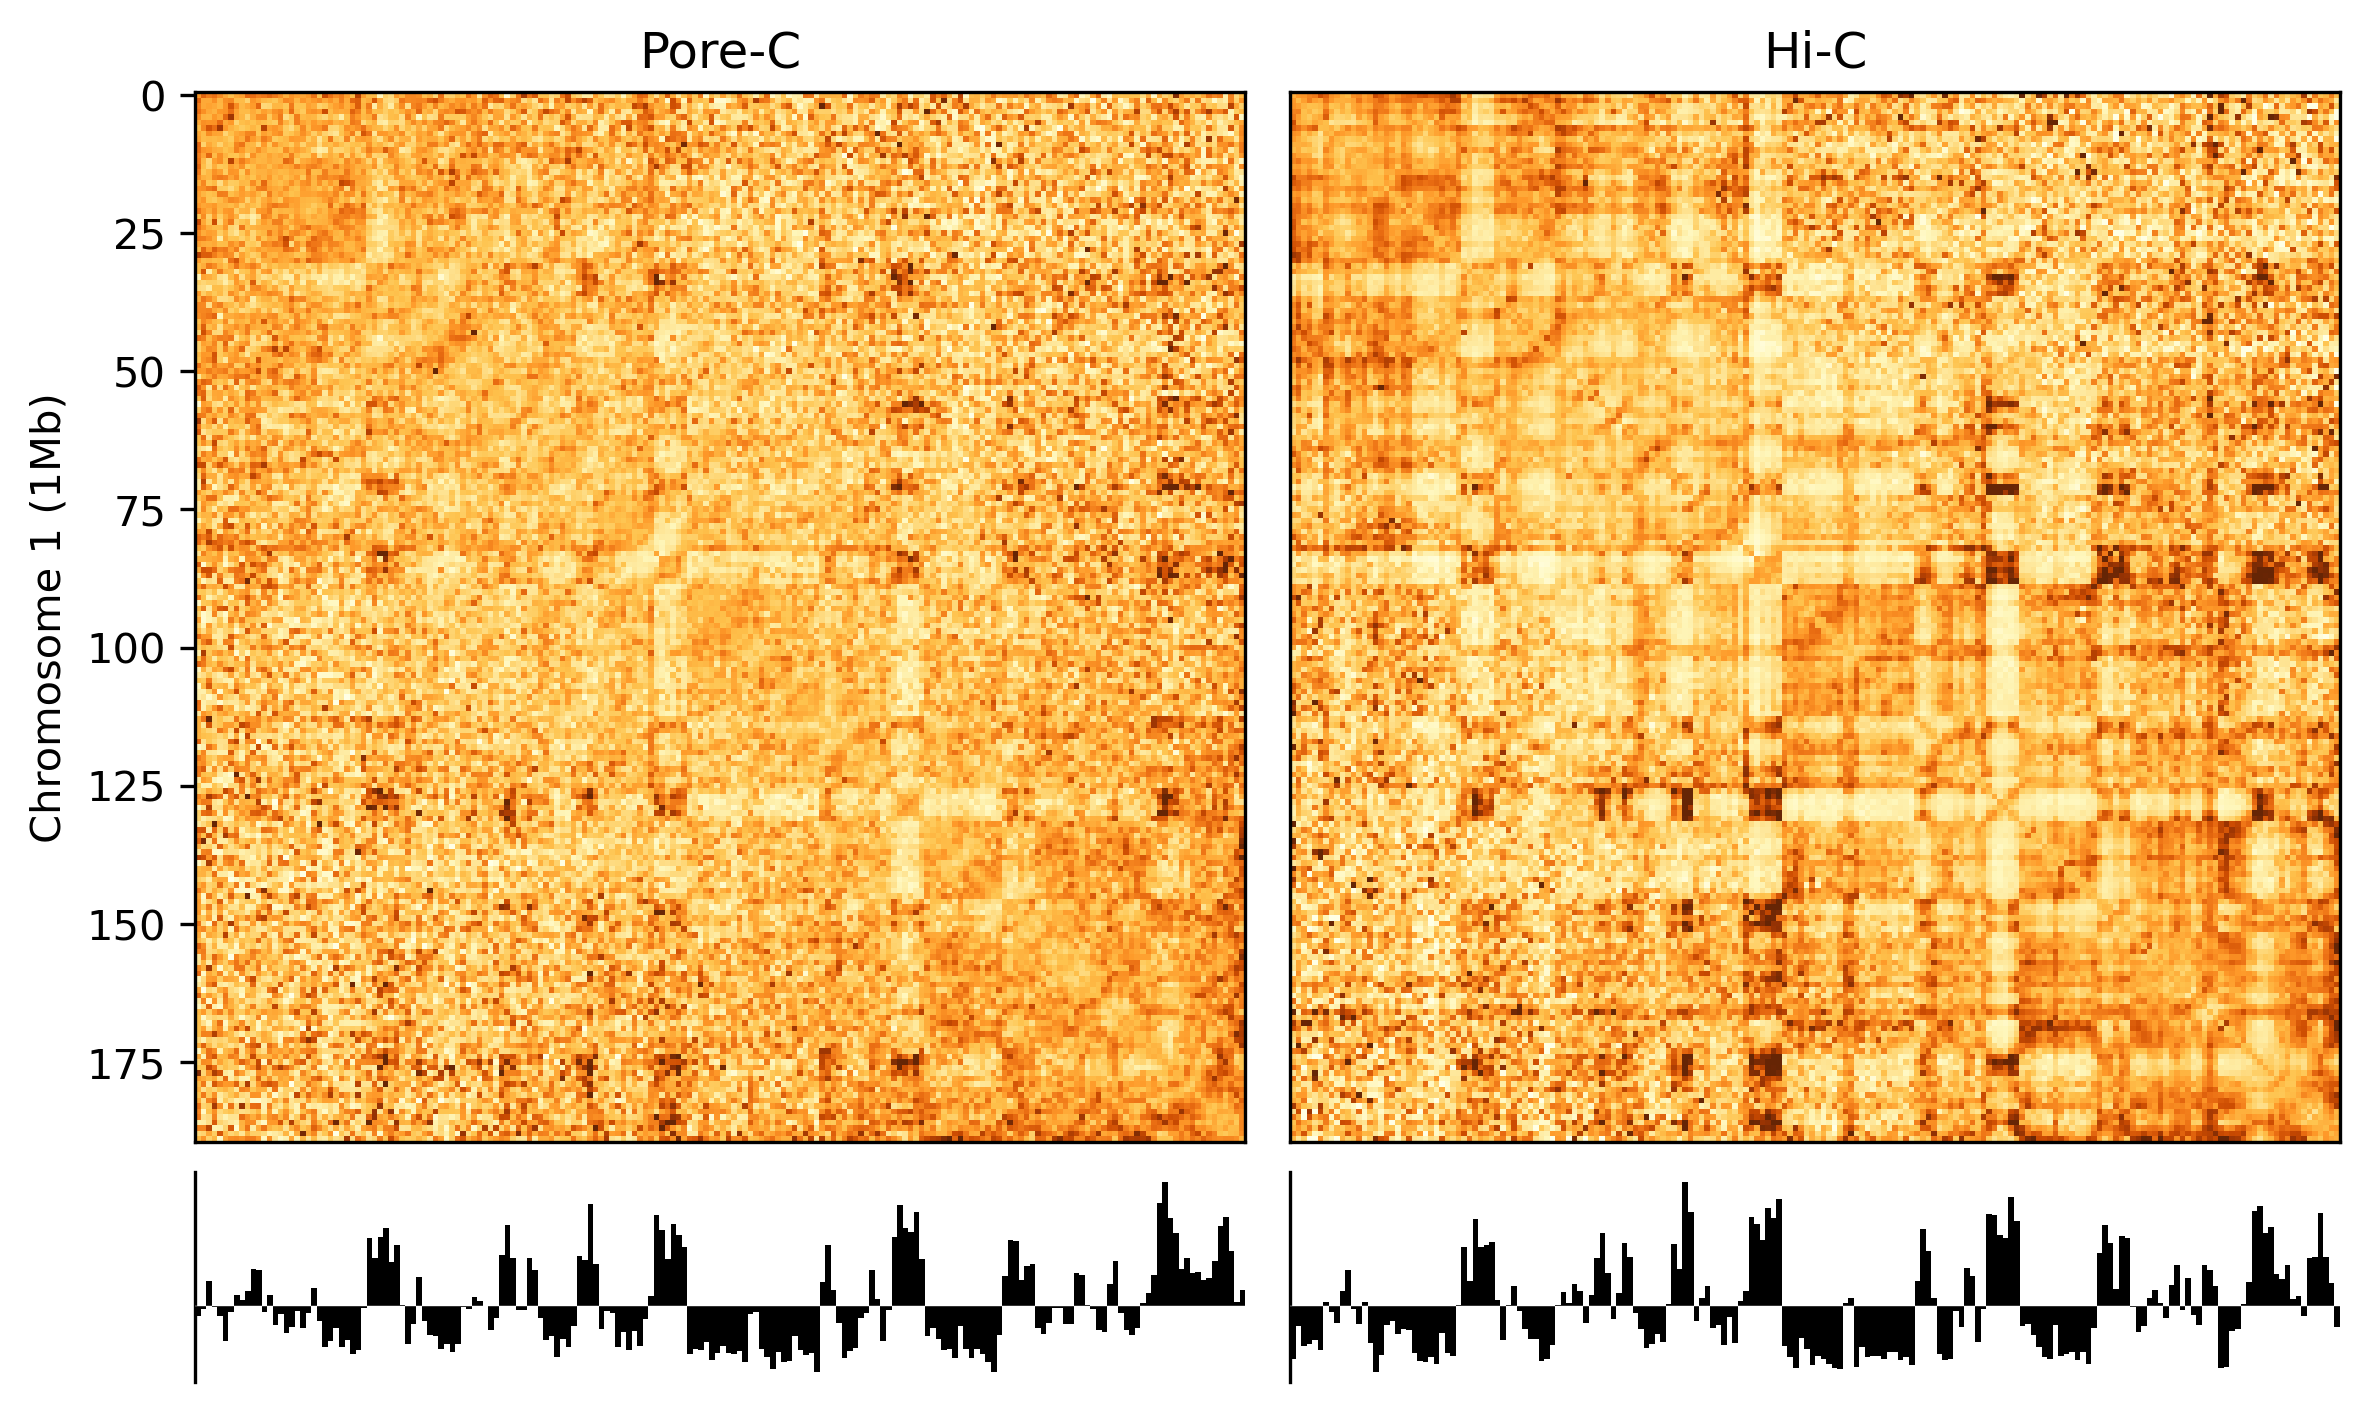

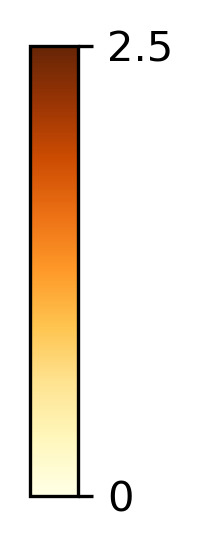

In [23]:
cmap = 'YlOrBr'
vmax = 2.5

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 8, 4

fig, axs = plt.subplots(1, 2, figsize=(8, 8))

print(f"{Apc_norm.shape=}")
print(f"{Ahic_norm.shape=}")

# Pore-C
im1 = axs[0].imshow(
    Apc_norm, 
    cmap=cmap,
    vmax=vmax,
    aspect='equal',
)
axs[0].set_title('Pore-C')

# Hi-C
im2 = axs[1].imshow(
    Ahic_norm, 
    cmap=cmap,
    vmax=vmax,
    aspect='equal',
)
axs[1].set_title('Hi-C')

# Calculate and plot leading principal component for Pore-C
pca = PCA(n_components=1)
pc_scores = pca.fit_transform(np.asarray(Apc_norm))
pc_scores_z = np.ravel(zscore(pc_scores))

divider = make_axes_locatable(axs[0])
ax_pc = divider.append_axes("bottom", size="20%", pad=0.1, sharex=axs[0])  # Adjust size and pad as needed
# ax_pc.plot(pc_scores_z, color='k',  lw=1, zorder=5)
ax_pc.bar(range(len(pc_scores_z)), pc_scores_z,  width=1, color='k', zorder=5) 
ax_pc.axhline(y=0, c='w', zorder=10, lw=.1)
ax_pc.set_yticks([])
sns.despine(ax=ax_pc, bottom=True)

# Calculate and plot leading principal component for Hi-C
pca = PCA(n_components=1)
pc_scores = pca.fit_transform(np.asarray(Ahic_norm))
pc_scores_z = np.ravel(zscore(pc_scores))

divider = make_axes_locatable(axs[1])
ax_hic = divider.append_axes("bottom", size="20%", pad=0.1, sharex=axs[1])  # Adjust size and pad as needed
# ax_hic.plot(pc_scores_z, color='k', lw=1, zorder=5)
ax_hic.bar(range(len(pc_scores_z)), pc_scores_z, width=1, color='k', zorder=5)
ax_hic.axhline(y=0, c='w', zorder=10, lw=.1)
ax_hic.set_xticks([])
ax_hic.set_yticks([])
sns.despine(ax=ax_hic, bottom=True)

# # Adjust layout
axs[0].set_xticks([])
axs[0].set_ylabel("Chromosome 1 (1Mb)")
axs[1].set_xticks([])
axs[1].set_yticks([])

plt.tight_layout()
plt.show()

# Assuming plt2.make_colorbar is defined elsewhere
plt2.make_colorbar(cmap, tick_labels=[0, vmax])

In [27]:
# Calculate and plot leading principal component for Pore-C
pca = PCA(n_components=1)
pc_scores = pca.fit_transform(np.asarray(Apc_norm))
pc_scores_z = np.ravel(zscore(pc_scores))

# Calculate and plot leading principal component for Hi-C
pca = PCA(n_components=1)
hic_scores = pca.fit_transform(np.asarray(Ahic_norm))
hic_scores_z = np.ravel(zscore(hic_scores))

print(f"{pc_scores_z.shape=} {hic_scores_z.shape=}")

scipy.stats.pearsonr(pc_scores_z, hic_scores_z)

pc_scores_z.shape=(190,) hic_scores_z.shape=(190,)


PearsonRResult(statistic=0.9263409184762776, pvalue=1.2059347994776923e-81)

In [31]:
print(f"{np.sum(Apc)=}")
print(f"{np.sum(Ahic)=}")
print(f"{np.sum(Apc)/np.sum(Ahic)=}")

np.sum(Apc)=882684.0
np.sum(Ahic)=13851731
np.sum(Apc)/np.sum(Ahic)=0.06372373243459609


In [32]:
scipy.stats.pearsonr(Apc.ravel(), Ahic.ravel())

PearsonRResult(statistic=0.90711024824556, pvalue=0.0)

In [33]:
882684.0 / 2

441342.0

In [25]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

# explore all

In [ ]:

def f_norm_submatrix_diff(matrix1, matrix2, n, sample_size=1):
    """Calculates the F-norm of the difference between randomly sampled submatrices.

    Args:
        matrix1 (np.ndarray): The first symmetric matrix.
        matrix2 (np.ndarray): The second symmetric matrix.
        n (int): The size of the submatrices to sample.
        sample_size (int, optional): Number of submatrix samples to take. Defaults to 1.

    Returns:
        list: A list containing:
            * float: The average F-norm over the sampled submatrices.
            * tuple: The average centroid coordinates (row, column) across samples. 
    """

    if matrix1.shape != matrix2.shape:
        raise ValueError("Matrices must have the same dimensions.")
    if not (np.allclose(matrix1, matrix1.T) and np.allclose(matrix2, matrix2.T)):
        raise ValueError("Matrices must be symmetric.")

    f_norms = []
    centroids = []
    for _ in range(sample_size):
        # Randomly select top-left corner of submatrices
        row_idx = np.random.randint(0, matrix1.shape[0] - n)
        col_idx = np.random.randint(0, matrix2.shape[1] - n)

        submatrix1 = matrix1[row_idx:row_idx + n, col_idx:col_idx + n]
        submatrix2 = matrix2[row_idx:row_idx + n, col_idx:col_idx + n]

        diff = submatrix1 - submatrix2
        f_norms.append(np.linalg.norm(diff, ord='fro')) 

        # Calculate centroid (center of mass)
        centroid = (row_idx + n//2, col_idx + n//2) 
        centroids.append(centroid)

    return f_norms, centroids

sample_size = 100000
submat = 15
f_norms, centroids = f_norm_submatrix_diff(Apc, Ahic, n=submat, sample_size=sample_size)

x, y = zip(*centroids)
s = plt.scatter(x, y, c=f_norms, s=1, ec='none', cmap='RdYlGn_r', alpha=0.4)
plt.scatter(y, x, c=f_norms, s=1, ec='none', cmap='RdYlGn', alpha=0.4)
plt.colorbar(s, label=r"$||A_{pc} - A_{hic}||_{F}$", shrink=0.75) 
plt.gca().set_aspect('equal')
plt.xticks([])
plt.gca().invert_yaxis()
plt.title("Local Differences")

In [ ]:
# break

In [ ]:
# row sums
deg_pc = np.array(Apc_norm.sum(axis=1)).ravel()
deg_hic = np.array(Ahic_norm.sum(axis=1)).ravel()

n = deg_pc.shape[0]

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 7, 4
fig, axs = plt.subplots(3, 1, sharex=True)

axs[0].bar(range(n), ut.normalize_1d_array(deg_pc))
axs[1].bar(range(n), ut.normalize_1d_array(deg_hic))
axs[2].bar(range(n), ut.normalize_1d_array(deg_pc) - ut.normalize_1d_array(deg_hic))

axs[0].set_title('Pop Pore-C Degree')
axs[1].set_title('Pop Hi-C Degree')
axs[2].set_title('Difference')

r, p = scipy.stats.pearsonr(deg_pc, deg_hic)
print(f"{r=:.3f} {p=:.5f}")

plt.tight_layout()

In [ ]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 2

plt.plot(ut.normalize_1d_array(deg_pc), marker="o", markersize=2, lw=1, label='Pore-C')
plt.plot(ut.normalize_1d_array(deg_hic), marker="+", markersize=2, lw=1, label='Hi-C')
plt.legend()

plt.ylabel('Normalized Degree')
plt.xlabel('Chrom 1 Loci (1Mb)')

In [ ]:
# diagonal
diag_pc = np.diag(Apc_norm)
diag_hic = np.diag(Ahic_norm)

n = diag_pc.shape[0]

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 7, 4
fig, axs = plt.subplots(3, 1, sharex=True)

axs[0].bar(range(n), ut.normalize_1d_array(diag_pc))
axs[1].bar(range(n), ut.normalize_1d_array(diag_hic))
axs[2].bar(range(n), ut.normalize_1d_array(diag_pc) - ut.normalize_1d_array(diag_hic))

axs[0].set_title('Pop Pore-C Diagonal')
axs[1].set_title('Pop Hi-C Diagonal')
axs[2].set_title('Difference')

r, p = scipy.stats.pearsonr(diag_pc, diag_hic)
print(f"{r=:.3f} {p=:.5f}")

plt.tight_layout()

In [ ]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 2

plt.plot(ut.normalize_1d_array(diag_pc), marker="o", markersize=2, lw=1, label='Pore-C')
plt.plot(ut.normalize_1d_array(diag_hic), marker="+", markersize=2, lw=1, label='Hi-C')
plt.legend()

plt.ylabel('Normalized Diagonal')
plt.xlabel('Chrom 1 Loci (1Mb)')

# principle eigenvectors

In [ ]:
vpc, wpc = np.linalg.eigh(Apc_norm)
vhic, whic = np.linalg.eigh(Ahic_norm)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 3
plt.plot(ut.normalize_1d_array(vpc[::-1]),  marker="o", markersize=2, lw=1, label='Pore-C')
plt.plot(ut.normalize_1d_array(vhic[::-1]), marker="+", markersize=2, lw=1, label='Hi-C')

plt.yscale('log')
plt.legend()

plt.ylabel('Normalized Eigenvalue (log)')
plt.xlabel('Eigenvalue Index')

In [ ]:
ab_pc = np.array(wpc[:, -1]).ravel()
ab_hic = np.array(whic[:, -1]).ravel()

ab_pc = ab_pc - ab_pc.mean()
ab_hic = ab_hic - ab_hic.mean()

n = ab_pc.shape[0]

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 7, 4
fig, axs = plt.subplots(2, 1, sharex=True)

axs[0].bar(range(n), ab_pc)
axs[1].bar(range(n), ab_hic)
# axs[2].bar(range(n), ab_pc - ab_hic)

axs[0].set_title('Pop Pore-C Eigenvector 1')
axs[1].set_title('Pop Hi-C Eigenvector 1')
# axs[2].set_title('Difference')

r, p = scipy.stats.pearsonr(ab_pc, ab_hic)
print(f"{r=:.3f} {p=:.5f}")

plt.tight_layout()

In [ ]:
def sum_k_diagonals(matrix):
    """Calculates the sum of all k diagonals in a symmetric matrix.

    Args:
        matrix (np.ndarray): The input symmetric matrix.

    Returns:
        list: A list of sums, where each element represents the sum of a diagonal.
    """

    if not np.allclose(matrix, matrix.T):
        raise ValueError("Input matrix must be symmetric.")

    n = matrix.shape[0]
    result = []

    # Extract elements along each diagonal
    for i in range(n-1):
        diagonal = np.diag(matrix, k=i)
        row = {
            'distance' : i,
            'contacts' : np.sum(diagonal),
        }
        result.append(row)

    return pd.DataFrame(result)
        
        
res_pc = sum_k_diagonals(Apc)
res_hic = sum_k_diagonals(Ahic)

res_pc['normalized_contacts'] = res_pc['contacts'] / res_pc['contacts'].sum()
res_hic['normalized_contacts'] = res_hic['contacts'] / res_hic['contacts'].sum()

plt.rcParams['figure.dpi'] = 200

plt.rcParams['figure.figsize'] = 3, 3
plt.plot(res_pc['distance'],
         res_pc['normalized_contacts'], label='Pore-C')

plt.plot(res_hic['distance'],
         res_hic['normalized_contacts'], label='Hi-C')

plt.yscale('log')
plt.legend()
plt.ylabel('Normalized Contacts')
plt.xlabel('Contact Distance (Mb)')

In [ ]:
break

In [ ]:
plt.imshow(I)

In [ ]:
def clique_expand_incidence(I, zero_diag=True):
    """A function to clique expand an incidence matrix """
    node_list = I.index
    A = np.dot(I, I.T)
    if zero_diag:
        A = A - np.diag(np.diag(A))
    A = pd.DataFrame(A, columns=node_list,
                     index=node_list)
    return A
    
A = clique_expand_incidence(I)    
plt.imshow(A)

In [ ]:
A = np.dot(I, I.T)
A = A - np.diag(np.diag(A))
plt.imshow(A)

np.diag(A)

In [ ]:
def explicit_clique_expand(I):
    """A function to perform explicit clique-expansion 
    of an incidence matrix """
    n, h = I.shape
    node_list = I.index
    A = np.zeros((n , n))

    for h in I.columns:
        ind = np.argwhere(I[h] > 0).ravel()
        pairs = list(itertools.combinations(ind, 2))

        for i, j in pairs:
            A[i, j] += 1
            A[j, i] += 1

    return A
    

A_exp = explicit_clique_expand(I)
plt.imshow(A_exp)

In [ ]:
plt.imshow(A_exp - A)

In [ ]:
np.diag(A)

In [ ]:
np.diag(A_exp)

In [ ]:
break